# Introduction
Use *Forecasting Patient Volume and Resource Demand to Better Inform Nurse Staffing Decisions* by Schienker et al. to predict Average Daily Census (ADC, daily number of filled beds).
### Problem Statement
Use Database of Daily Census Count per department to forecast ADC more accuractely than Schienker (**Error**).
### Experimental Procedure
EDA: Prepare data for machine learning pipeline. Dive into seasonality, averaging, differencing...
<br>Feature engineering: Split data by lag (tn-l for l features) and forecast distance (yn+m for m predictions). 
<br>Modeling: Run LSTM and GRU RNN models and ARIMA model.
<br>Results: Compare models to test set.
<br>Evaluate: Error compared to Schienker.

In [1]:
# Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import time
# Modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM,GRU,Dropout, TimeDistributed
import xgboost as xgb
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


In [2]:
df = pd.read_excel('AvgDailyCensusPerDept2Years.xlsx')
df.sort_values(by='EffectiveDAte',inplace=True)
display(df.head())
print(df.dtypes)

,EffectiveDAte,DepartmentName,DepartmentAbbreviation,AverageCensusCount
6139,2016-01-01,COMPREHENSIVE CARE PGM,CCP,8
6741,2016-01-01,3 NORTH,3N,10
7901,2016-01-01,F2-MATERNITY,F2,21
4737,2016-01-01,PICN 1,PICN1,11
4061,2016-01-01,SEQ SPEC CARE NURSERY,SEQN,4


EffectiveDAte             datetime64[ns]
DepartmentName                    object
DepartmentAbbreviation            object
AverageCensusCount                 int64
dtype: object


# EDA

In [3]:
name_counts = df['DepartmentName'].value_counts()
print("Unique Names",len(name_counts))
abb_counts = df['DepartmentAbbreviation'].value_counts()
print("Unique Abbreviations",len(abb_counts))

Unique Names 44
Unique Abbreviations 44


In [4]:
# look at PICUs ACC and average ACC per day
df_PICU = df[df['DepartmentName'] == "PICU"].reset_index(drop=True)
df_alldept = df.groupby(['EffectiveDAte']).mean()
display(df_PICU.head())

,EffectiveDAte,DepartmentName,DepartmentAbbreviation,AverageCensusCount
0,2016-03-28,PICU,PICU,22
1,2016-03-29,PICU,PICU,22
2,2016-03-30,PICU,PICU,22
3,2016-03-31,PICU,PICU,21
4,2016-04-01,PICU,PICU,21


In [5]:
# and PICU ADC and Total ADC
df_alldept_M = df.groupby(pd.Grouper(key='EffectiveDAte',freq='M')).mean()
df_PICU_M = df_PICU.groupby(pd.Grouper(key='EffectiveDAte',freq='M')).mean()

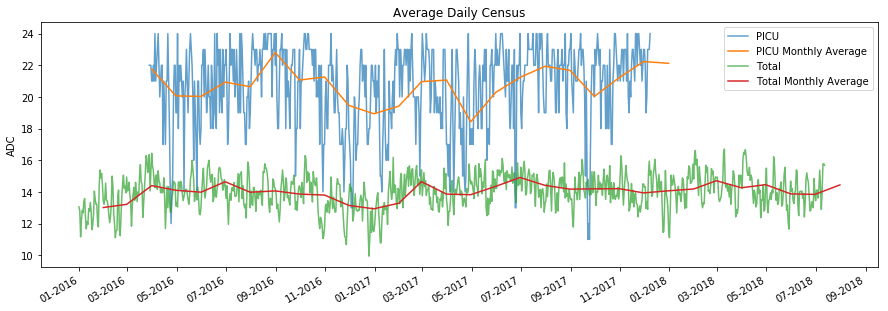

In [6]:
#plot ADC
plt.figure(figsize=(15,5))
plt.plot(df_PICU['EffectiveDAte'],df_PICU['AverageCensusCount'],label="PICU",alpha=.7)
plt.plot(df_PICU_M,label="PICU Monthly Average",alpha=1)
plt.plot(df_alldept,label="Total",alpha=.7)
plt.plot(df_alldept_M,label="Total Monthly Average",alpha=1)
plt.title("Average Daily Census")
plt.ylabel("ADC")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

In [7]:
freq=30 # assume monthly frequency
s_PICU = sm.tsa.seasonal_decompose(df_PICU['AverageCensusCount'].values,freq=freq)

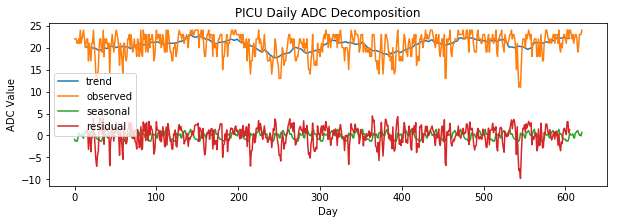

In [8]:
# look at trend, seasonal, resid and observed
plt.figure(figsize=(10,3))
plt.plot(s_PICU.trend,label="trend")
plt.plot(s_PICU.observed,label="observed")
plt.plot(s_PICU.seasonal,label="seasonal")
plt.plot(s_PICU.resid,label="residual")
plt.title("PICU Daily ADC Decomposition")
plt.ylabel("ADC Value")
plt.xlabel("Day")
plt.legend()
plt.show()

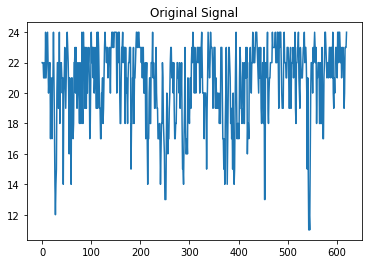

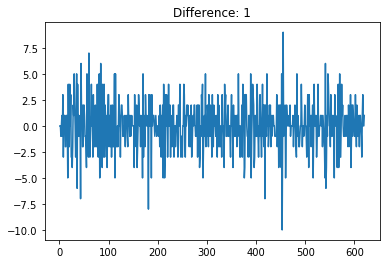

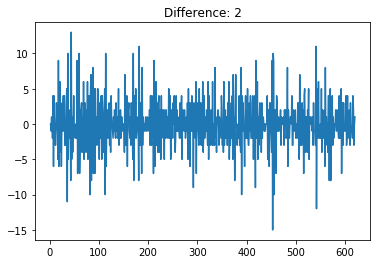

In [9]:
# find order of stationarity
plt.plot(range(len(df_PICU.index)),df_PICU["AverageCensusCount"])
plt.title("Original Signal")
plt.show()
# difference: 1
dif_1 = df_PICU['AverageCensusCount'] - df_PICU['AverageCensusCount'].shift()
plt.plot(range(len(dif_1)),dif_1)
plt.title("Difference: 1")
plt.show()
# difference: 2
dif_2 = dif_1 - dif_1.shift()
plt.plot(range(len(dif_2)),dif_2)
plt.title("Difference: 2")
plt.show()

The original signal is not stationary, so we look at the first few difference orders to get a stationary signal. The first two orders are stationary, so we'll include these orders in our parameter grid search for ARIMA.

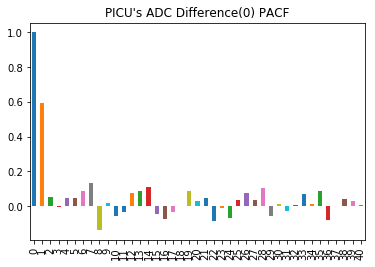

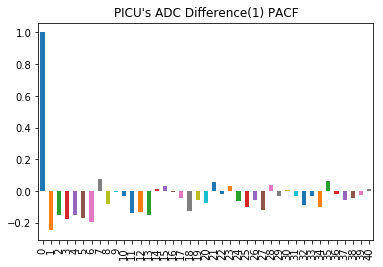

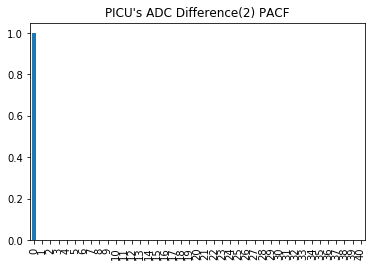

In [10]:
# look at (partial) autocorrelation of differenced signals
x_acf = pd.DataFrame()
x_acf['signal'] = pacf(df_PICU['AverageCensusCount'])
x_acf['signal'].plot(kind='bar')
plt.title("PICU's ADC Difference(0) PACF")
plt.show()
x_acf['dif_1'] = pacf(dif_1[1:])
x_acf['dif_1'].plot(kind='bar')
plt.title("PICU's ADC Difference(1) PACF")
plt.show()
x_acf['dif_2'] = pacf(dif_2[1:])
x_acf['dif_2'].plot(kind='bar')
plt.title("PICU's ADC Difference(2) PACF")
plt.show()

                              ARIMA Model Results                               
Dep. Variable:     D.AverageCensusCount   No. Observations:                  620
Model:                   ARIMA(2, 1, 2)   Log Likelihood               -1333.908
Method:                         css-mle   S.D. of innovations              2.077
Date:                  Sat, 11 Aug 2018   AIC                           2679.817
Time:                          17:44:43   BIC                           2706.395
Sample:                               1   HQIC                          2690.148
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0021      0.005      0.425      0.671      -0.008       0.012
ar.L1.D.AverageCensusCount     0.1140      0.379      0.301      0.

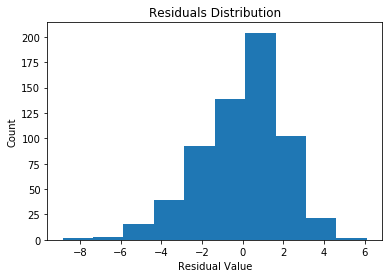

In [11]:
model = ARIMA(df_PICU['AverageCensusCount'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())
plt.hist(model_fit.resid)
plt.title("Residuals Distribution")
plt.xlabel("Residual Value")
plt.ylabel("Count")
plt.show()

# Feature Engineering

In [12]:
# sequential split
def seq_split(df,window_size=7):
    X = df.copy()
    df_temp = df.copy()
    for i in range(window_size):
        X = pd.concat([df_temp.shift(i+1),X],axis=1)
    return X.dropna(axis=0)

In [13]:
test_size = 60
train_size = len(df_PICU.index) - test_size
window_size=7
df_PICU_train = seq_split(df_PICU['AverageCensusCount'][:train_size],window_size=window_size)
df_PICU_test = seq_split(df_PICU['AverageCensusCount'][train_size:],window_size=window_size)
print("Training DataFrame")
display(df_PICU_train.head())
X_PICU_train = df_PICU_train.iloc[:,:-1]
Y_PICU_train = df_PICU_train.iloc[:,-1]
X_PICU_test = df_PICU_test.iloc[:,:-1]
Y_PICU_test = df_PICU_test.iloc[:,-1]
# reshape for LSTM
X_PICU_train = np.reshape(X_PICU_train.values, (len(X_PICU_train), 1, X_PICU_train.shape[1]))
X_PICU_test = np.reshape(X_PICU_test.values, (len(X_PICU_test), 1, X_PICU_test.shape[1]))
print("Training X")
print(X_PICU_train[:5,0,:])
print("Training Y")
display(Y_PICU_train.head())

Training DataFrame


,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount,AverageCensusCount
7,22.0,22.0,22.0,21.0,21.0,22.0,21.0,24
8,22.0,22.0,21.0,21.0,22.0,21.0,24.0,21
9,22.0,21.0,21.0,22.0,21.0,24.0,21.0,22
10,21.0,21.0,22.0,21.0,24.0,21.0,22.0,23
11,21.0,22.0,21.0,24.0,21.0,22.0,23.0,24


Training X
[[22. 22. 22. 21. 21. 22. 21.]
 [22. 22. 21. 21. 22. 21. 24.]
 [22. 21. 21. 22. 21. 24. 21.]
 [21. 21. 22. 21. 24. 21. 22.]
 [21. 22. 21. 24. 21. 22. 23.]]
Training Y


7     24
8     21
9     22
10    23
11    24
Name: AverageCensusCount, dtype: int64

# Modeling

### ARIMA

In [14]:
# setup arima
order = (2,1,7)
X_arima_train = df_PICU['AverageCensusCount'][:train_size]
Y_arima_test = df_PICU['AverageCensusCount'][train_size:]
arima_model = ARIMA(X_arima_train, 
                      order=order
                     )
arima_model_fit = arima_model.fit()

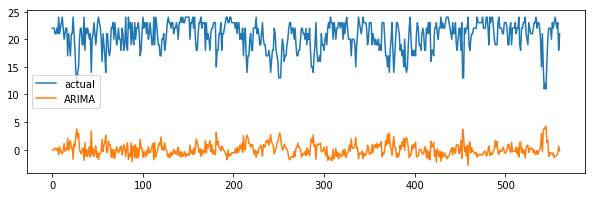

In [15]:
# in-sample predictions
arima_train_predict = arima_model_fit.predict(start=1,end=train_size)
# trained values
plt.figure(figsize=(10,3))
plt.plot(range(len(X_arima_train.index)),X_arima_train,label="actual")
plt.plot(range(len(arima_train_predict)),arima_train_predict,label="ARIMA")
plt.legend()
plt.show()

ARIMA Error 1.7676347411033824


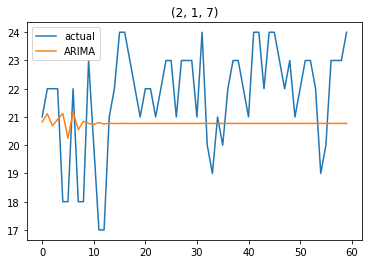

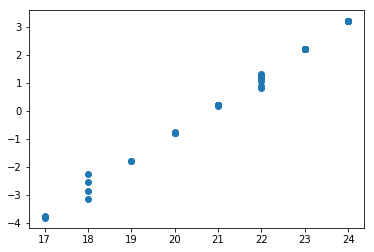

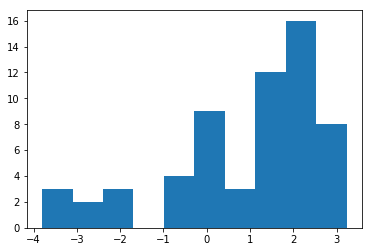

In [16]:
# out-of-sample forecast
arima_forecast,_,_ = arima_model_fit.forecast(test_size)
# error
arima_res = Y_arima_test.values - arima_forecast
arima_mae = np.mean(abs(arima_res))
print("ARIMA Error",arima_mae)
#plot out-of-sample time series
plt.plot(range(len(Y_arima_test.index)),Y_arima_test,label="actual")
plt.plot(range(len(Y_arima_test.index)),arima_forecast,label="ARIMA")
plt.title(order)
plt.legend()
plt.show()
# plot errors
plt.scatter(Y_arima_test,arima_res)
plt.show()
# histogram of errors
plt.hist(arima_res)
plt.show()

### XGBoost

In [17]:
# xgboost features
df_PICU_xgb = df_PICU[['EffectiveDAte','AverageCensusCount']].reset_index(drop=True)
df_PICU_xgb['year'] = df_PICU_xgb['EffectiveDAte'].dt.year
df_PICU_xgb['month'] = df_PICU_xgb['EffectiveDAte'].dt.month
df_PICU_xgb['dayofweek'] = df_PICU_xgb['EffectiveDAte'].dt.dayofweek
df_PICU_xgb['lpch_main_open'] = 0
df_PICU_xgb.loc[df_PICU_xgb["EffectiveDAte"] < '2017-12-09']['lpch_main_open'] = 1
offset=30
window=30
for i in range(len(df_PICU_xgb.index))[offset+window:]:
    win_range = df_PICU_xgb.loc[i-window-offset:i-offset,'AverageCensusCount']
    df_PICU_xgb.loc[i,'prev_mean'] = win_range.mean()
    df_PICU_xgb.loc[i,'prev_std'] = win_range.std()

X_PICU_xgb = df_PICU_xgb[['year','month','dayofweek','lpch_main_open','prev_mean','prev_std']]
Y_PICU_xgb = df_PICU_xgb['AverageCensusCount']
# sequential train test split
X_PICU_xgb_train = X_PICU_xgb.iloc[X_PICU_xgb.index[:train_size]]
X_PICU_xgb_test = X_PICU_xgb.iloc[X_PICU_xgb.index[train_size:]]
Y_PICU_xgb_train = Y_PICU_xgb.iloc[Y_PICU_xgb.index[:train_size]]
Y_PICU_xgb_test = Y_PICU_xgb.iloc[Y_PICU_xgb.index[train_size:]]

In [18]:
# linear regression
lr_model = LinearRegression()
lr_features = ["prev_mean","prev_std","dayofweek","month"]#,"year","lpch_main_open"]
lr_X_train = X_PICU_xgb_train[lr_features].fillna(0)
lr_X_test = X_PICU_xgb_test[lr_features].fillna(0)
lr_model.fit(lr_X_train, Y_PICU_xgb_train)
print("Linear Regression R Squared",lr_model.score(lr_X_train,Y_PICU_xgb_train))

Linear Regression R Squared 0.032511437797456466


Linear Regression MAE: 1.7842


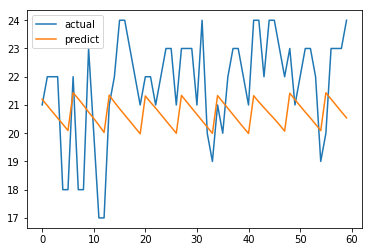

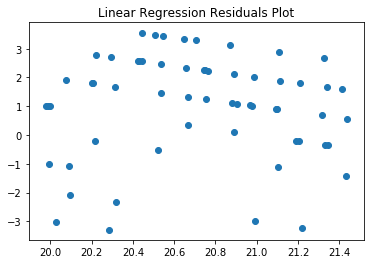

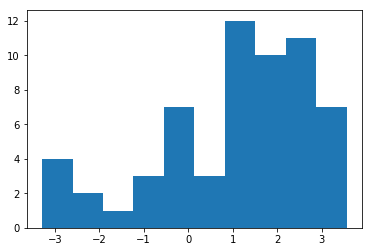

In [19]:
lr_pred = lr_model.predict(lr_X_test)
print("Linear Regression MAE: {:0.4f}".format(np.mean(abs(Y_PICU_xgb_test-lr_pred))))
# plot time series
plt.plot(range(len(Y_PICU_xgb_test.index)),Y_PICU_xgb_test,label='actual')
plt.plot(lr_pred,label='predict')
plt.legend()
plt.show()
# error
lr_res = Y_PICU_xgb_test - lr_pred
plt.scatter(lr_pred,lr_res)
plt.title("Linear Regression Residuals Plot")
plt.show()
plt.hist(lr_res)
plt.show()

In [20]:
params = {"objective":"reg:linear",
          "eta":0.1,
          "max_depth":3,
          "silent":1,
          "eval_metric":"mae",
          "min_child_weight":5,
          "subsample":.75,
          "colsample_bytree":0.7,
          "seed":42}

In [21]:
# setup XGBoost
xgb_train = xgb.DMatrix(X_PICU_xgb_train, label=Y_PICU_xgb_train)
xgb_test = xgb.DMatrix(X_PICU_xgb_test, label=Y_PICU_xgb_test)
watchlist = [ (xgb_train,'train'), (xgb_test, 'test') ]
xgb_PICU_model = xgb.train(params, xgb_train, num_boost_round=500, evals=watchlist, early_stopping_rounds=20)

[0]	train-mae:18.104	test-mae:19.2146
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 20 rounds.
[1]	train-mae:16.3059	test-mae:17.4128
[2]	train-mae:14.6815	test-mae:15.779
[3]	train-mae:13.2111	test-mae:14.3086
[4]	train-mae:11.8998	test-mae:12.9973
[5]	train-mae:10.7105	test-mae:11.7971
[6]	train-mae:9.65289	test-mae:10.7298
[7]	train-mae:8.69891	test-mae:9.7683
[8]	train-mae:7.85192	test-mae:9.06366
[9]	train-mae:7.0842	test-mae:8.47816
[10]	train-mae:6.40911	test-mae:7.77825
[11]	train-mae:5.81215	test-mae:7.13935
[12]	train-mae:5.28389	test-mae:6.83403
[13]	train-mae:4.81582	test-mae:6.33936
[14]	train-mae:4.38921	test-mae:6.00757
[15]	train-mae:4.01666	test-mae:5.69126
[16]	train-mae:3.69576	test-mae:5.29347
[17]	train-mae:3.41009	test-mae:4.9677
[18]	train-mae:3.15993	test-mae:4.76288
[19]	train-mae:2.94771	test-mae:4.55089
[20]	train-mae:2.7613	test-mae:4.35702
[21]	train-mae:2.59956	test-mae:4.1

XGB Error 2.716594378153483


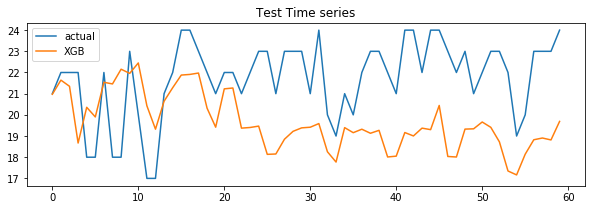

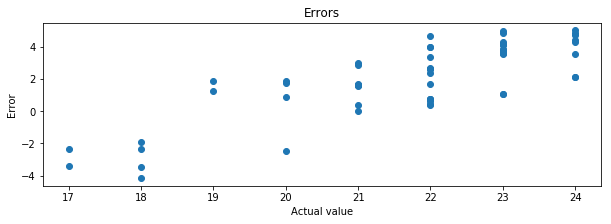

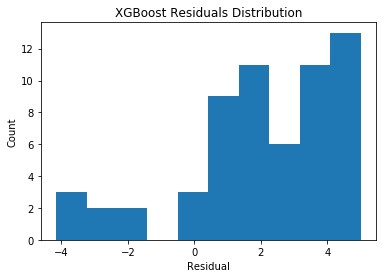

In [22]:
# predict
Y_PICU_xgb_pred = xgb_PICU_model.predict(xgb.DMatrix(X_PICU_xgb_test))
# error
PICU_xgb_res = Y_PICU_xgb_test-Y_PICU_xgb_pred
PICU_xgb_mae = np.mean(abs(PICU_xgb_res))
print("XGB Error",PICU_xgb_mae)
# plot time series
plt.figure(figsize=(10,3))
plt.plot(range(len(Y_PICU_xgb_test.index)),Y_PICU_xgb_test,label="actual")
plt.plot(Y_PICU_xgb_pred,label="XGB")
plt.title("Test Time series")
plt.legend()
plt.show()
# plot errors
plt.figure(figsize=(10,3))
plt.scatter(Y_PICU_xgb_test,PICU_xgb_res)
plt.title("Errors")
plt.xlabel("Actual value")
plt.ylabel("Error")
plt.show()
# histogram of errors
plt.hist(PICU_xgb_res)
plt.title("XGBoost Residuals Distribution")
plt.ylabel("Count")
plt.xlabel("Residual")
plt.show()

Our XGBoost model tends to underestimate, shown by the density of our errors located above zero. However, the time series shows adaptability and may be useful in showing how patient volume changes by the day as well as by the month.

### GRU

In [23]:
# forecast 30 days
# setup target variable
rnn_forecast_size = 30
Y_temp_seq_train = seq_split(Y_PICU_train,window_size=rnn_forecast_size)
Y_temp_seq_test = seq_split(Y_PICU_test,window_size=rnn_forecast_size)
#reshape outputs
Y_PICU_train_rnn = np.reshape(Y_temp_seq_train.values,(Y_temp_seq_train.shape[0],1,Y_temp_seq_train.shape[1]))
Y_PICU_test_rnn = np.reshape(Y_temp_seq_test.values,(Y_temp_seq_test.shape[0],1,Y_temp_seq_test.shape[1]))
X_PICU_train_rnn = X_PICU_train[:-rnn_forecast_size]
X_PICU_test_rnn = X_PICU_test[:-rnn_forecast_size]
print(X_PICU_train_rnn.shape,Y_PICU_train_rnn.shape,Y_temp_seq_test.shape)

(524, 1, 7) (524, 1, 31) (23, 31)


In [24]:
gru = Sequential()
gru.add(GRU(64,input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
gru.add(TimeDistributed(Dense(rnn_forecast_size+1)))

# compile and fit the model
gru.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
# fit
start_time = time.time()
gru_history = gru.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=50, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=1,
                            validation_data=(X_PICU_test_rnn,Y_PICU_test_rnn)
                           )
end_time = time.time()-start_time

Train on 524 samples, validate on 23 samples
Epoch 1/50
524/524 [==============================] - 2s 3ms/step - loss: 376.0496 - mean_absolute_error: 19.1860 - val_loss: 372.7302 - val_mean_absolute_error: 19.2267
Epoch 2/50
524/524 [==============================] - 0s 568us/step - loss: 277.2595 - mean_absolute_error: 16.4047 - val_loss: 276.3071 - val_mean_absolute_error: 16.5261
Epoch 3/50
524/524 [==============================] - 0s 530us/step - loss: 200.6967 - mean_absolute_error: 13.8807 - val_loss: 202.1687 - val_mean_absolute_error: 14.1069
Epoch 4/50
524/524 [==============================] - 0s 587us/step - loss: 141.0741 - mean_absolute_error: 11.5377 - val_loss: 143.5144 - val_mean_absolute_error: 11.8472
Epoch 5/50
524/524 [==============================] - 0s 553us/step - loss: 96.2074 - mean_absolute_error: 9.4080 - val_loss: 100.7692 - val_mean_absolute_error: 9.8855
Epoch 6/50
524/524 [==============================] - 0s 539us/step - loss: 65.1890 - mean_absolute_

524/524 [==============================] - 0s 568us/step - loss: 6.8420 - mean_absolute_error: 2.1394 - val_loss: 4.4367 - val_mean_absolute_error: 1.8313
Epoch 50/50
524/524 [==============================] - 0s 522us/step - loss: 6.8433 - mean_absolute_error: 2.1396 - val_loss: 4.4382 - val_mean_absolute_error: 1.8316


Training time: 16.132 seconds
Loss 4.438
Mean Absolute Error 1.832


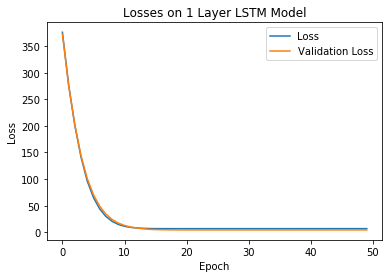

In [25]:
# show score
print("Training time: {:0.3f} seconds".format(end_time))
gru_predict = gru.predict(X_PICU_test_rnn)
gru_score = gru.evaluate(X_PICU_test_rnn,Y_PICU_test_rnn,verbose=0)
print("Loss {:0.3f}".format(gru_score[0]))
print("Mean Absolute Error {:0.3f}".format(gru_score[1]))
# plot loss
plt.plot(gru_history.history['loss'],label="Loss")
plt.plot(gru_history.history['val_loss'],label="Validation Loss")
plt.title("Losses on 1 Layer LSTM Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### LSTM

In [26]:
lstm_1 = Sequential()
lstm_1.add(LSTM(32, input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
lstm_1.add(TimeDistributed(Dense(rnn_forecast_size+1)))

# compile and fit the model
lstm_1.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
start_time = time.time()
lstm_1_history = lstm_1.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=150, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=1,
                            validation_data=(X_PICU_test_rnn,Y_PICU_test_rnn)
                           )
end_time = time.time()-start_time

Train on 524 samples, validate on 23 samples
Epoch 1/150
524/524 [==============================] - 2s 4ms/step - loss: 409.6409 - mean_absolute_error: 20.0661 - val_loss: 442.7697 - val_mean_absolute_error: 20.9840
Epoch 2/150
524/524 [==============================] - 0s 683us/step - loss: 371.3596 - mean_absolute_error: 19.0870 - val_loss: 406.3222 - val_mean_absolute_error: 20.0968
Epoch 3/150
524/524 [==============================] - 0s 563us/step - loss: 339.5475 - mean_absolute_error: 18.2348 - val_loss: 373.8479 - val_mean_absolute_error: 19.2720
Epoch 4/150
524/524 [==============================] - 0s 630us/step - loss: 310.7354 - mean_absolute_error: 17.4271 - val_loss: 343.9487 - val_mean_absolute_error: 18.4800
Epoch 5/150
524/524 [==============================] - 0s 568us/step - loss: 284.1677 - mean_absolute_error: 16.6475 - val_loss: 316.1806 - val_mean_absolute_error: 17.7129
Epoch 6/150
524/524 [==============================] - 0s 544us/step - loss: 259.5528 - mean

Epoch 49/150
524/524 [==============================] - 0s 463us/step - loss: 6.8089 - mean_absolute_error: 2.1609 - val_loss: 4.8963 - val_mean_absolute_error: 1.9372
Epoch 50/150
524/524 [==============================] - 0s 404us/step - loss: 6.7979 - mean_absolute_error: 2.1552 - val_loss: 4.8002 - val_mean_absolute_error: 1.9157
Epoch 51/150
524/524 [==============================] - 0s 549us/step - loss: 6.7904 - mean_absolute_error: 2.1505 - val_loss: 4.7205 - val_mean_absolute_error: 1.8975
Epoch 52/150
524/524 [==============================] - 0s 487us/step - loss: 6.7853 - mean_absolute_error: 2.1465 - val_loss: 4.6547 - val_mean_absolute_error: 1.8823
Epoch 53/150
524/524 [==============================] - 0s 421us/step - loss: 6.7820 - mean_absolute_error: 2.1431 - val_loss: 4.6006 - val_mean_absolute_error: 1.8696
Epoch 54/150
524/524 [==============================] - 0s 413us/step - loss: 6.7800 - mean_absolute_error: 2.1404 - val_loss: 4.5563 - val_mean_absolute_error:

Epoch 98/150
524/524 [==============================] - 0s 444us/step - loss: 6.7932 - mean_absolute_error: 2.1315 - val_loss: 4.3948 - val_mean_absolute_error: 1.8202
Epoch 99/150
524/524 [==============================] - 0s 553us/step - loss: 6.7934 - mean_absolute_error: 2.1316 - val_loss: 4.3950 - val_mean_absolute_error: 1.8203
Epoch 100/150
524/524 [==============================] - 0s 725us/step - loss: 6.7936 - mean_absolute_error: 2.1316 - val_loss: 4.3951 - val_mean_absolute_error: 1.8203
Epoch 101/150
524/524 [==============================] - 0s 456us/step - loss: 6.7938 - mean_absolute_error: 2.1316 - val_loss: 4.3953 - val_mean_absolute_error: 1.8204
Epoch 102/150
524/524 [==============================] - 0s 506us/step - loss: 6.7940 - mean_absolute_error: 2.1317 - val_loss: 4.3954 - val_mean_absolute_error: 1.8204
Epoch 103/150
524/524 [==============================] - 0s 525us/step - loss: 6.7942 - mean_absolute_error: 2.1317 - val_loss: 4.3956 - val_mean_absolute_er

524/524 [==============================] - 0s 463us/step - loss: 6.7970 - mean_absolute_error: 2.1321 - val_loss: 4.3979 - val_mean_absolute_error: 1.8211
Epoch 147/150
524/524 [==============================] - 0s 503us/step - loss: 6.7970 - mean_absolute_error: 2.1321 - val_loss: 4.3980 - val_mean_absolute_error: 1.8211
Epoch 148/150
524/524 [==============================] - 0s 450us/step - loss: 6.7970 - mean_absolute_error: 2.1321 - val_loss: 4.3979 - val_mean_absolute_error: 1.8211
Epoch 149/150
524/524 [==============================] - 0s 429us/step - loss: 6.7970 - mean_absolute_error: 2.1321 - val_loss: 4.3980 - val_mean_absolute_error: 1.8211
Epoch 150/150
524/524 [==============================] - 0s 399us/step - loss: 6.7970 - mean_absolute_error: 2.1321 - val_loss: 4.3980 - val_mean_absolute_error: 1.8211


Training time: 41.57 seconds
Loss 4.398
Mean Absolute Error 1.821


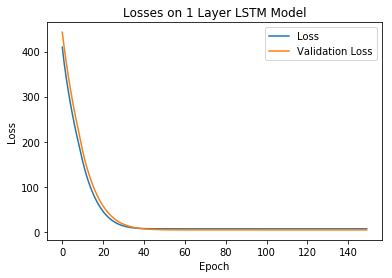

In [27]:
# show score
print("Training time: {:0.2f} seconds".format(end_time))
lstm_predict = lstm_1.predict(X_PICU_test_rnn)
lstm_1_score = lstm_1.evaluate(X_PICU_test_rnn,Y_PICU_test_rnn,verbose=0)
print("Loss {:0.3f}".format(lstm_1_score[0]))
print("Mean Absolute Error {:0.3f}".format(lstm_1_score[1]))
# plot loss
plt.plot(lstm_1_history.history['loss'],label="Loss")
plt.plot(lstm_1_history.history['val_loss'],label="Validation Loss")
plt.title("Losses on 1 Layer LSTM Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Results

In [28]:
# daily rnn predict 
print(lstm_predict.shape)

(23, 1, 31)


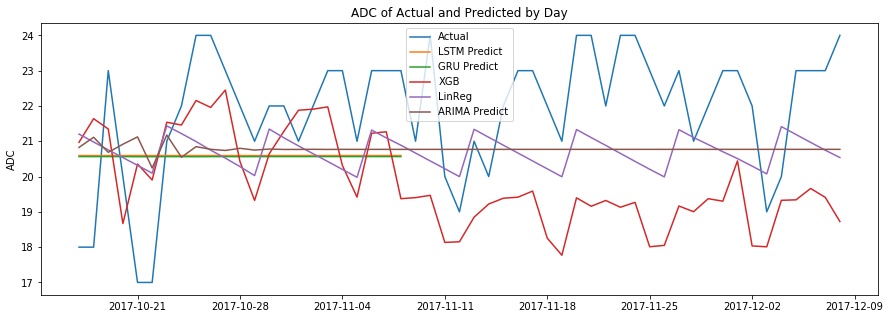

In [29]:
# show error on predicted ADC Daily
plt.figure(figsize=(15,5))
df_PICU_true = df_PICU.loc[int(len(df_PICU.index)*.66):,:]
x_eval_dates = df_PICU['EffectiveDAte'].loc[Y_PICU_test.index]
plt.plot(x_eval_dates,Y_PICU_test.values,label="Actual")
plt.plot(df_PICU['EffectiveDAte'].loc[Y_PICU_test.index[:-rnn_forecast_size]],lstm_predict[:,0,0], label="LSTM Predict")
plt.plot(df_PICU['EffectiveDAte'].loc[Y_PICU_test.index[:-rnn_forecast_size]],gru_predict[:,0,0], label="GRU Predict")
plt.plot(x_eval_dates,Y_PICU_xgb_pred[:len(Y_PICU_test.index)],label="XGB")
plt.plot(x_eval_dates,lr_pred[:len(Y_PICU_test.index)],label="LinReg")
plt.plot(x_eval_dates,arima_forecast[:len(Y_PICU_test.index)], label="ARIMA Predict")
plt.title("ADC of Actual and Predicted by Day")
plt.ylabel("ADC")
plt.legend()
plt.show()

In [30]:
# find Monthly averages
df_PICU_true_M = df_PICU_true.groupby(by=[df_PICU_true.EffectiveDAte.dt.month]).mean()
test_months = {4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
start_date = '2016-03-28'
df_time_eval = pd.DataFrame()
### forecast arrays
arima_forecasts,xgb_forecasts,lr_forecasts,gru_forecasts,lstm_forecasts = [],[],[],[],[]
for test_month in list(test_months.keys())[1:]:
    # use all data up until first day of next month
    end_date = "2017-" + str(test_month-1) + "-" + str(test_months[test_month-1])
    df_PICU_curr = df_PICU[df_PICU['EffectiveDAte'].isin(pd.date_range(start = start_date,end=end_date))]
    ### train models
    # arima
    start_time = time.time()
    arima_model = ARIMA(df_PICU_curr['AverageCensusCount'], 
                      order=order
                     )
    arima_model_fit = arima_model.fit()
    arima_forecast,_,_ = arima_model_fit.forecast(steps=test_months[test_month])
    arima_forecasts.append(arima_forecast)
    df_time_eval.loc[test_month,"ARIMA"] = time.time()-start_time
    # xgb
    start_time=time.time()
    Y_PICU_curr_xgb = df_PICU_curr['AverageCensusCount']
    X_PICU_curr_xgb = X_PICU_xgb[df_PICU_xgb["EffectiveDAte"].isin(pd.date_range(start=start_date,end=end_date))]
    next_month = pd.date_range(start=end_date,end="2017-" + str(test_month) + "-" + str(test_months[test_month]))
    X_PICU_pred_xgb = X_PICU_xgb[df_PICU_xgb["EffectiveDAte"].isin(next_month)]
    xgb_PICU_model = xgb.train(params, xgb.DMatrix(X_PICU_curr_xgb,label=Y_PICU_curr_xgb), num_boost_round=500)
    xgb_forecasts.append(xgb_PICU_model.predict(xgb.DMatrix(X_PICU_pred_xgb)))
    df_time_eval.loc[test_month,"XGB"] = time.time()-start_time
    # Linear Regression
    start_time=time.time()
    lr_model = LinearRegression()
    lr_model.fit(X_PICU_curr_xgb.fillna(0),Y_PICU_curr_xgb)
    lr_forecasts.append(lr_model.predict(X_PICU_pred_xgb.fillna(0)))
    df_time_eval.loc[test_month,"LinReg"] = time.time()-start_time
    # GRU / LSTM
    df_seq_train = seq_split(df_PICU_curr['AverageCensusCount'],window_size=window_size)
    X_PICU_train_rnn_temp = df_seq_train.iloc[:,:-1]
    Y_PICU_train_rnn_temp = df_seq_train.iloc[:,-1]
    # reshape for LSTM
    X_PICU_train_rnn = np.reshape(X_PICU_train_rnn_temp.values, (len(X_PICU_train_rnn_temp), 1, X_PICU_train_rnn_temp.shape[1]))
    rnn_forecast_size = test_months[test_month]
    Y_seq_train = seq_split(Y_PICU_train_rnn_temp,window_size=rnn_forecast_size)
    #reshape outputs
    Y_PICU_train_rnn = np.reshape(Y_seq_train.values,(Y_seq_train.shape[0],1,Y_seq_train.shape[1]))
    Y_PICU_train_rnn = Y_PICU_train_rnn[:-1]
    X_PICU_train_rnn = X_PICU_train_rnn[:-(rnn_forecast_size+1)]
    X_PICU_test_rnn = X_PICU_train_rnn[-1]
    X_PICU_test_rnn = np.reshape(X_PICU_test_rnn,(X_PICU_test_rnn.shape[0],1,X_PICU_test_rnn.shape[1]))
    # train models
        # gru
    start_time = time.time()
    gru = Sequential()
    gru.add(GRU(64,input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
    gru.add(TimeDistributed(Dense(rnn_forecast_size+1)))
    gru.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
    gru_history = gru.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=50, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=0
                           )
    df_time_eval.loc[test_month,"GRU"] = time.time()-start_time
    # lstm
    start_time=time.time()
    lstm_1 = Sequential()
    lstm_1.add(LSTM(32, input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
    lstm_1.add(TimeDistributed(Dense(rnn_forecast_size+1)))
    lstm_1.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
    lstm_1_history = lstm_1.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=150, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=0
                           )
    df_time_eval.loc[test_month,"LSTM"] = time.time()-start_time
    # predict
    gru_forecasts.append(gru.predict(X_PICU_test_rnn))
    lstm_forecasts.append(lstm_1.predict(X_PICU_test_rnn))
# average each month and add to results df
arima_forecasts_means=[]
xgb_forecasts_means = []
lr_forecasts_means = []
gru_forecasts_means = []
lstm_forecasts_means= []
for month in range(len(arima_forecasts)):
    arima_forecasts_means.append(np.mean(arima_forecasts[month]))
    xgb_forecasts_means.append(np.mean(xgb_forecasts[month]))
    lr_forecasts_means.append(np.mean(lr_forecasts[month]))
    gru_forecasts_means.append(np.mean(gru_forecasts[month]))
    lstm_forecasts_means.append(np.mean(lstm_forecasts[month]))
df_PICU_true_M['ARIMA'] = arima_forecasts_means
df_PICU_true_M['XGBoost'] = xgb_forecasts_means
df_PICU_true_M['Linear Regression'] = lr_forecasts_means
df_PICU_true_M['GRU'] = gru_forecasts_means
df_PICU_true_M['LSTM'] = lstm_forecasts_means

display(df_PICU_true_M)

,AverageCensusCount,ARIMA,XGBoost,Linear Regression,GRU,LSTM
EffectiveDAte,,,,,,
5,20.666667,18.882866,20.148758,18.703622,20.446592,20.454002
6,21.233333,20.364038,21.017292,19.102773,20.335993,20.348106
7,21.935484,20.811254,19.945023,19.782516,20.370113,20.400539
8,21.677419,21.540881,22.000669,20.399057,20.420546,20.459490
9,20.033333,21.845094,20.320843,20.821483,20.509254,20.546072
10,21.225806,19.787702,19.024225,20.555961,20.567656,20.582722
11,22.233333,21.015673,20.450762,20.973646,20.580523,20.590065
12,22.125000,22.080145,20.662542,21.122663,20.632729,20.636703


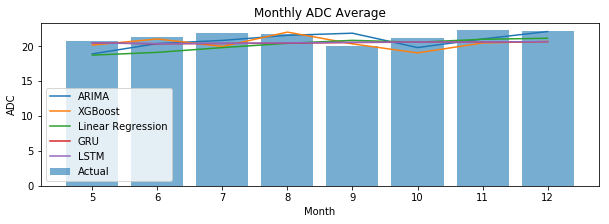

ARIMA	 1.0532804485207476 +/- 0.674037406762846
XGBoost	 1.0977226595724785 +/- 0.8440831870888286
LinReg	 1.4056192834005605 +/- 0.5997083124672996
GRU	 1.0273516701113792 +/- 0.5422807143631048
LSTM	 1.0172691868197532 +/- 0.5320288901381074


ARIMA      4.715000
XGB        0.300663
LinReg     0.006163
GRU       11.386842
LSTM      26.310252
dtype: float64

In [32]:
# show averaged monthly ADC
plt.figure(figsize=(10,3))
plt.bar(df_PICU_true_M.index,df_PICU_true_M['AverageCensusCount'],label="Actual",alpha=.6)
plt.plot(df_PICU_true_M.index,df_PICU_true_M['ARIMA'],label="ARIMA")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['XGBoost'],label="XGBoost")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['Linear Regression'],label="Linear Regression")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['GRU'],label="GRU")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['LSTM'],label="LSTM")
plt.title("Monthly ADC Average")
plt.ylabel("ADC")
plt.xlabel("Month")
plt.legend()
plt.show()
# error metrics
arima_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['ARIMA'])
xgb_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['XGBoost'])
lr_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['Linear Regression'])
gru_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['GRU'])
lstm_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['LSTM'])
print("ARIMA\t",arima_error.mean(),"+/-",arima_error.std())
print("XGBoost\t",xgb_error.mean(),"+/-",xgb_error.std())
print("LinReg\t",lr_error.mean(),"+/-",lr_error.std())
print("GRU\t",gru_error.mean(),"+/-",gru_error.std())
print("LSTM\t",lstm_error.mean(),"+/-",lstm_error.std())
# training time
df_time_eval.mean()

# Evaluation